# Logistic Regression

In [1]:
#imports for typing
import pandas
import numpy
import sklearn
import datasets

#Real imports
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

#our library
from preprocessing import basic, stemming, lemming

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/atomesz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/atomesz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
dataset : datasets.dataset_dict.DatasetDict = load_dataset("imdb")

Reusing dataset imdb (/home/atomesz/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
x_train : list = dataset["train"][:]["text"]
y_train : list = dataset["train"][:]["label"]

x_test : list = dataset["test"][:]["text"]
y_test : list = dataset["test"][:]["label"]

In [4]:
original_x_test = x_test.copy()

## Preprocessing

In [5]:
import functools
from multiprocessing import Pool

preprocess_func = basic
remove_stopwords = True

with Pool() as p:
    x_train : list = p.map(functools.partial(preprocess_func, remove_stopwords=remove_stopwords), x_train)
    x_test : list = p.map(functools.partial(preprocess_func, remove_stopwords=remove_stopwords), x_test)


-----------------------------------

## Logistic Regression

We use the following features :

    1 if "no" appear in the doc, 0 otherwise
    The count of first and second pronouns in the document
    1 if "!" is in the document, 0 otherwise
    log(word count in the document)
    Number of words in the document which are in the positive lexicon
    Number of words in the document which are in the negative lexicon
    -----------
    Number of "."
    Number of words of length < 3 characters
    Number of ":" (simplist version of a smiley, could do a regexp)


#### Vader Sentiment

In [6]:
vs : pandas.core.frame.DataFrame = pd.read_csv("vader_lexicon.txt", sep="\t", names=["TOKEN", "MEAN-SENTIMENT-RATING", "STANDARD DEVIATION", "RAW-HUMAN-SENTIMENT-RATINGS"])
vs.head()

,TOKEN,MEAN-SENTIMENT-RATING,STANDARD DEVIATION,RAW-HUMAN-SENTIMENT-RATINGS
0,$:,-1.5,0.80623,"[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]"
1,%),-0.4,1.01980,"[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]"
2,%-),-1.5,1.43178,"[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]"
3,&-:,-0.4,1.42829,"[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]"
4,&:,-0.7,0.64031,"[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]"


In [7]:
vs_dict : dict = dict(zip(vs.TOKEN, vs["MEAN-SENTIMENT-RATING"]))

#### Feature building

In [8]:
def get_features(review : str):
    """
    Get the features of a string for the logistic regression
    
    Parameters
    ----------
    review : str
        A review of the dataset

    Returns
    -------
    ints
        The features
    """
    #init
    threshold : float = 1.9
    feature_no : int = 0
    feature_pronun : int = 0
    feature_pos : int = 0
    feature_neg : int = 0
    feature_wlen : int = 0
    str_split : str = review.split()

    if "no" in str_split:
        feature_no = 1
    
    for word in str_split:
        if word in vs_dict:
            if vs_dict[word] < -threshold:
                feature_neg += 1
            elif vs_dict[word] > threshold:
                feature_pos += 1
        if word == "you" or word == "I":
            feature_pronun += 1
        if len(word) <= 3:
            feature_wlen += 1
    
    feature_smiley : int = review.count(":")
    feature_excl : int = (review.find("!") != -1)
    feature_log : float = np.log(len(str_split))
    feature_dot : int = review.count(".")
    return feature_no, feature_pronun, feature_excl, feature_log, feature_pos, feature_neg, feature_dot, feature_wlen, feature_smiley



def logistic_transformation(x : list):
    """
    Get the features all dataset x for the logistic regression
    
    Parameters
    ----------
    x : list
        List of strings

    Returns
    -------
    numpy.ndarray
        Features of each string
    """
    nbr_features : int = 9
    res : numpy.ndarray = np.zeros((len(x), nbr_features))
    for i, elt in enumerate(x):
        res[i][0], res[i][1],res[i][2],res[i][3],res[i][4], res[i][5], res[i][6],res[i][8], res[i][7] = get_features(elt)
    return res

In [9]:
%%time
lr_x_train : numpy.ndarray = logistic_transformation(x_train)

CPU times: user 608 ms, sys: 5.96 ms, total: 614 ms
Wall time: 614 ms


In [10]:
%%time
lr_x_test : numpy.ndarray = logistic_transformation(x_test)

CPU times: user 568 ms, sys: 1.33 ms, total: 569 ms
Wall time: 568 ms


In [11]:
print(lr_x_train)

[[ 0.  0.  0. ...  0.  0.  5.]
 [ 0.  0.  0. ...  0.  0. 13.]
 [ 0.  0.  0. ...  0.  0.  3.]
 ...
 [ 0.  0.  0. ...  0.  0. 11.]
 [ 0.  0.  0. ...  0.  0.  3.]
 [ 0.  0.  0. ...  0.  0.  6.]]


We compute the logistic regression with the help of sklearn

In [12]:
lr : sklearn.linear_model._logistic.LogisticRegression = LogisticRegression(random_state=42, solver="saga", max_iter = 100000, penalty='l2').fit(lr_x_train, y_train)
# Without the max_iter, it fails to converge

### Prediction
The result is predicted :

In [13]:
y_pred : numpy.ndarray = lr.predict(lr_x_test)
accuracy_score(y_test, y_pred)

0.71272

We obtain an accuracy of 0.70248 with all the features set.

#### Without preprocessing
Threshold | Acc | Notes
----------|-----|------
1 | 0.69668
1.8 | 0.69488
1.9 | 0.70248 | with all new features
2 | 0.6978
2.2 | 0.69508
3 | 0.64512
1.2 / -2 | 0.679

##### Accuracy when adding the new features

Without preprocessing

Regularization = l2

Threshold = 2

* Accuracy without = 0.6978
* Accuracy with feature "." = 0.69776
* Accuracy with feature word len < 3 = 0.69724
* Accuracy with feature simplist smiley = 0.69808

______________

So we can think that the feature word len is not really good but :

* Accuracy with feature "." and smiley = 0.69748
* Accuracy with all new features = 0.69912

### Precision, Recall and F1-score

In [14]:
# The accuracy is not the best to evaluate the prediction, we must see the recall and f1 score to really evaluate it.
precision_recall_fscore_support(y_test, y_pred)
#But the following array is not the best visually

(array([0.70143939, 0.72533898]),
 array([0.74072, 0.68472]),
 array([0.72054475, 0.70444444]),
 array([12500, 12500]))

<AxesSubplot:>

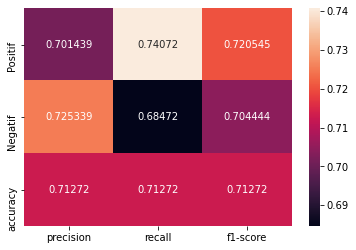

In [15]:
# So we can use an heatmap
clf_report : dict = classification_report(y_test,
                                   y_pred,
                                   target_names=["Positif", "Negatif"],
                                   output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-2].T, annot=True, fmt='g')

### Confusion matrix

<AxesSubplot:>

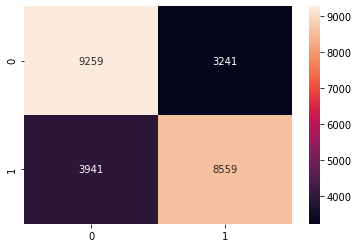

In [16]:
cm : numpy.ndarray = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

### Regularization 
We can do it directly in the logistic regression of sklearn as the parameter "penalty"

Regularization:

 / | None | l2 |
---------|-----|----|
Accuracy | 0.70244 | 0.70248 |


### Solver


Solver | None | l1 | l2 | Notes
---------|------|----|----|-----------
lbfgs | 0.70244 | / | 0.70248 | is the by-default solver
Saga | 0.70336 | 0.7034 | 0.70444 |  max_iter = 100000
newton-cg | 0.70244 | / | / | l2 couldn't converge
sag | 0.70296 | / | 0.70296 | 
liblinear | /  | 0.70276 | 0.70288 |

### Preprocessing
Preprocessing | Mean Accuracy | AccPos | AccNeg | recallPos | recallNeg | f1scorePos | f1scoreNeg | Notes
--------------|---------------|--------|--------|-----------|-----------|------------|------------|-----------
None | 0.7034 | 0.69454434 | 0.71310033 | 0.72616 | 0.68064 | 0.71000039 | 0.69649216 |
stopswords | 0.71272 | 0.70143939 | 0.72533898 | 0.74072 | 0.68472 | 0.72054475 | 0.70444444 | best strategy
stemming | 0.68688 | 0.68333072 | 0.69056942 | 0.69656 | 0.6772 | 0.68988194 | 0.68381937 |
lemming | 0.70844 | 0.70136796 | 0.71602686 | 0.726 | 0.69088 | 0.71347144 | 0.7032287 | 
lemming + stopwords | 0.70412 | 0.69360346 | 0.71584468 | 0.73128 | 0.67696 | 0.71194361 | 0.69585955 | we thought it could be the best strategy but no

In [17]:
from analyze import find_wrong_class

few_wrong = find_wrong_class(original_x_test, y_pred, y_test)

In [19]:
few_wrong[-2:]

[('Four things intrigued me as to this film - firstly, it stars Carly Pope (of "Popular" fame), who is always a pleasure to watch. Secdonly, it features brilliant New Zealand actress Rena Owen. Thirdly, it is filmed in association with the New Zealand Film Commission. Fourthly, a friend recommended it to me. However, I was utterly disappointed. The whole storyline is absurd and complicated, with very little resolution. Pope\'s acting is fine, but Owen is unfortunately under-used. The other actors and actresses are all okay, but I am unfamiliar with them all. Aside from the nice riddles which are littered throughout the movie (and Pope and Owen), this film isn\'t very good. So the moral of the story is...don\'t watch it unless you really want to.',
  1),
 ('David Bryce\'s comments nearby are exceptionally well written and informative as almost say everything I feel about DARLING LILI. This massive musical is so peculiar and over blown, over produced and must have caused ruptures at Para

# Analysis of misclassified samples

The first one starts really well but concludes on something negative which is not taken in account since we do not take words order into account.

The second one is purely ironical.

This is why those examples are misclassified.